<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Exercise: EM Connectomics</h3> 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os.path import join as pjoin
import skeleton_plot as skelplot
import meshparty
import cloudvolume

import sys
sys.path.append("..") # to access utils folder
from utils.skeleton_loading_utils import load_cv_skeleton

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This cell sets up a variable called `data_root` that you should use in any code below to access the dataset in question (e.g. paths to manifest files for the SDK should be made relative to this variable).
</div>

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/anatomy/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/anatomy/"
elif ('amzn2' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/anatomy/"
data_root

'/data/'

In [3]:
# Initialize cloud volume to access the EM skeletons
cv_obj = cloudvolume.CloudVolume(f"file://{data_root}/em_minnie65_v1078") 

In [4]:
def plot_skeleton(sk: meshparty.skeleton.Skeleton):
    """Plots a skeleton.
    
    Args:
        sk: meshparty skeleton
        
    Returns: 
        ax: plot axes
    """
    fig, ax = plt.subplots(figsize=(7, 10))
    skelplot.plot_tools.plot_skel(
        sk,
        ax=ax,
        line_width = 1,
        plot_soma = True,
        invert_y = True,
        x="x",
        y="y",
    )

    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['bottom'].set_visible(False)
    ax.axis('off')
    
    return ax

def filter_synapse_table(synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None):   
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """
    
    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        pre_m = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_m = np.ones(len(synapse_table), dtype=bool)
        
    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        post_m = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_m = np.ones(len(synapse_table), dtype=bool)
        
    return synapse_table[pre_m & post_m]

def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type", 
                         label_id_col: str = "pt_root_id", 
                         post_labels: pd.DataFrame = None, 
                         post_label_type_col: str = None, 
                         post_label_id_col: str = None):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids
        post_labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        post_label_type_col: column name in labels for cell types
        post_label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    
    if post_labels is None:
        post_labels = labels
    if post_label_type_col is None:
        post_label_type_col = label_type_col
    if post_label_id_col is None:
        post_label_id_col = label_id_col
        
    mat_sorted = mat.copy()
    
    pre_mat_labels = np.array(labels.set_index(label_id_col).loc[mat_sorted.index][label_type_col])
    pre_sorting = np.argsort(pre_mat_labels)

    post_mat_labels = np.array(post_labels.set_index(post_label_id_col).loc[mat_sorted.T.index][post_label_type_col])
    post_sorting = np.argsort(post_mat_labels)

    mat_sorted = mat_sorted.iloc[pre_sorting].T.iloc[post_sorting].T

    return mat_sorted, pre_mat_labels[pre_sorting], post_mat_labels[post_sorting]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

## Task 1: Inhibitory connectivity
    
    
In the workshop, we visualized the connectivity of excitatory neurons with each other. Here, we will extend this analysis to include inhibitory neurons. 
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 1.1
Load the proofreading, synapse and manual cell type information and filter the synapse table to only contain proofread neurons for which we have cell type information. Plot the synapse matrix.
    
</div>

In [5]:
proof_df = pd.read_feather(pjoin(data_root,"microns1078", "proofread_axons_microns_1078.feather"))
proof_syn_table = pd.read_feather(pjoin(data_root,"microns1078", "syn_proofread_axons_all_microns_1078.feather"))

cell_type_df = pd.read_feather(pjoin(data_root,"microns1078", "cell_types_microns_1078_manual.feather"))
cell_type_df = cell_type_df[cell_type_df["cell_type"] != "Unsure E"]
cell_type_df = cell_type_df[cell_type_df["cell_type"] != "Unsure I"]
cell_type_df = cell_type_df[np.isin(cell_type_df["pt_root_id"], proof_df["pt_root_id"])]

In [6]:
ct_ct_syn_table = filter_synapse_table(proof_syn_table, pre_root_ids=cell_type_df["pt_root_id"], post_root_ids=cell_type_df["pt_root_id"])


syn_mat = ct_ct_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                      values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)
syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

<Axes: xlabel='post_pt_root_id', ylabel='pre_pt_root_id'>

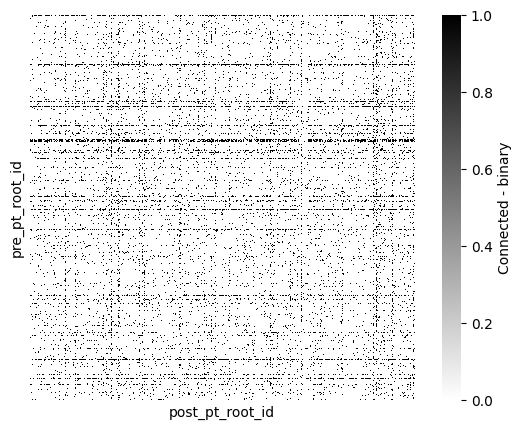

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 1.2
Sort the matrix using the cell type information and replot it.
    
</div>

In [8]:
syn_mat_ct, syn_mat_cell_types, _ = sort_matrix_by_types(syn_mat, cell_type_df)

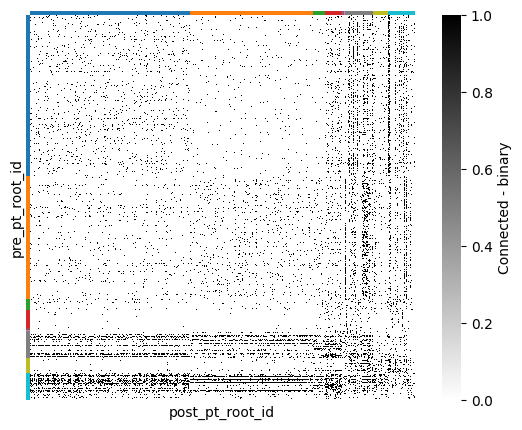

In [9]:
cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab10")(ct_idx)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})


# Adding row and column colors for cell types
for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.01, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))    

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 1.3
Next, we will revisit the synaptic connectivity of a single neuron. Select an excitatory neuron from the set of proofread neurons and plot its skeleton and outgoing synapses.
    
</div>

In [10]:
root_id = proof_df.iloc[2]["pt_root_id"]

sk = load_cv_skeleton(root_id, cv_obj)

pre_syns = filter_synapse_table(proof_syn_table, pre_root_ids=[root_id])

<Axes: xlabel='pre_pt_position_x', ylabel='pre_pt_position_y'>

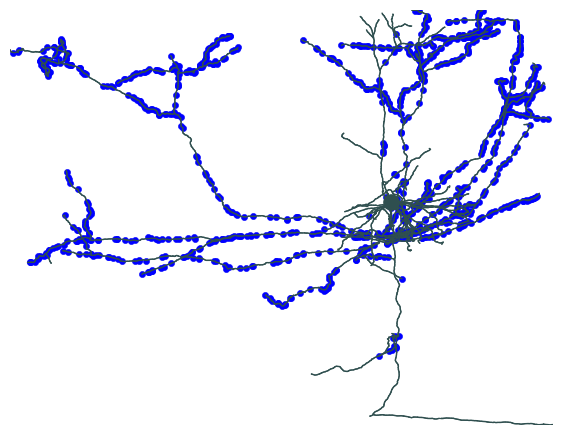

In [11]:
ax = plot_skeleton(sk)

sns.scatterplot(data=pre_syns, x="pre_pt_position_x", y="pre_pt_position_y", 
                s=20, c="b", ax=ax, edgecolor=None) 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 1.4
Color the outgoing synapses by their target type. Use the automated cell type prediction to color synapses by excitatory / inhibitory postsynaptic identity (the `classification_system` column in the cell type table can be used here). 
    
Multiple publications reported a bias for inhibitory targets being overrepresented on the initial part of the axon and excitatory targets being dominant on the distal sections. Can you tell this bias for your neuron as well? 
    
</div>

In [12]:
post_cell_type_df = pd.read_feather(pjoin(data_root, "microns1078", "cell_types_microns_1078_auto.feather"))

In [13]:
pre_syns_annot = pd.merge(pre_syns, post_cell_type_df[["pt_root_id", "cell_type", "classification_system"]], left_on="post_pt_root_id", right_on="pt_root_id", how="left")
pre_syns_annot["cell_type"].fillna("Unknown", inplace=True)
pre_syns_annot["cell_type"].value_counts()

cell_type
Unknown      381
23P          310
BC           104
5P-IT         87
6P-IT         74
6P-CT         50
MC            40
5P-ET         29
4P            26
BPC           13
NGC           11
5P-NP          4
astrocyte      2
microglia      1
Name: count, dtype: int64

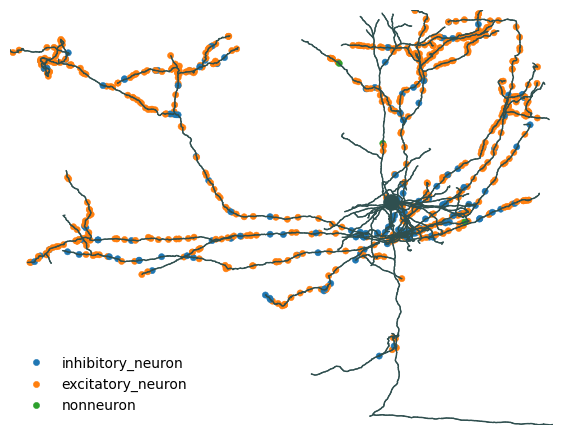

In [14]:
ax = plot_skeleton(sk)

sns.scatterplot(data=pre_syns_annot, x="pre_pt_position_x", y="pre_pt_position_y", 
                s=20, hue="classification_system", palette="tab10", ax=ax, edgecolor=None) 
ax.legend(frameon=False, loc="best")

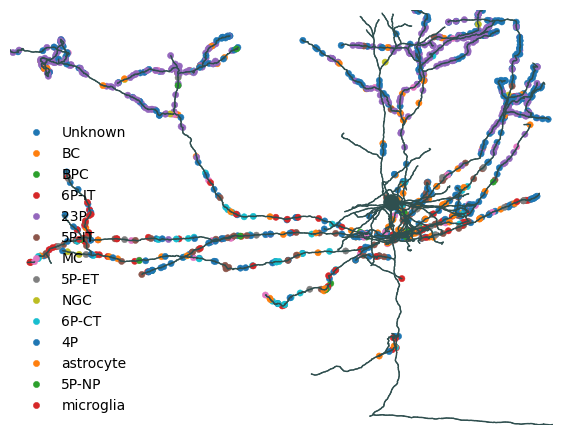

In [15]:
ax = plot_skeleton(sk)

sns.scatterplot(data=pre_syns_annot, x="pre_pt_position_x", y="pre_pt_position_y", 
                s=20, hue="cell_type", palette="tab10", ax=ax, edgecolor=None) 
ax.legend(frameon=False, loc="best")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

## Task 2: In/out degree of inhbitory neurons
    
Because cortical inhibitory neuron's axons are relatively local they can be mostly contained with the mm scale dataset.  Therefore, after proofreading a large fraction of their output synaspes can be reconstructed.  Their dendrites are also contained within the volume and so their inputs are largely complete as well.  Therefore one simple question is whether the number of inputs a particular interneuron of a particular class is related to the number of outputs that cell sends locally.  

This exercise is to ask that question of the dataset, by finding the total number of synaptic inputs and outputs from individual inhibitory neurons in the dataset, and make scatter plots of the number of inputs and outputs broken down by cell type. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 2.1
Using the proofread cells that are classfied as inhibitory, filter the proofread synapse table to only include ouputs from proofread inhibitory cells.  Then do the same to find the inputs to those same neurons in the dataset.  How many cells, total inputs and total outputs are there onto and from proofreading inhibitory cells?
</div>

In [16]:
inh_neurons_df = cell_type_df.query('classification_system =="aibs_coarse_inhibitory"')
inh_neurons = inh_neurons_df["pt_root_id"]
inh_neuron_out = filter_synapse_table(proof_syn_table, pre_root_ids=inh_neurons.values)
inh_neuron_in = filter_synapse_table(proof_syn_table, post_root_ids=inh_neurons.values)
print(len(inh_neurons), len(inh_neuron_out), len(inh_neuron_in))

150 417890 878632


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 2.2
Using group-bys and merges, construct a dataframe that contains a pt_root_id, it's total inputs, total outputs and cell type. 
    
Make a scatter plot of the number of inputs versus the number of outputs colored by cell type.  Do any cell types show a significant relationship? 
</div>

In [17]:
output_series = inh_neuron_out.groupby('pre_pt_root_id')['size'].count()
output_series.name = 'n_outputs'
input_series = inh_neuron_in.groupby('post_pt_root_id')['size'].count()
input_series.name='n_inputs'
in_out_df = pd.DataFrame([output_series, input_series]).T
in_out_df=in_out_df.merge(inh_neurons_df[['pt_root_id', 'cell_type']], left_index=True, right_on='pt_root_id')

<Axes: xlabel='n_outputs', ylabel='n_inputs'>

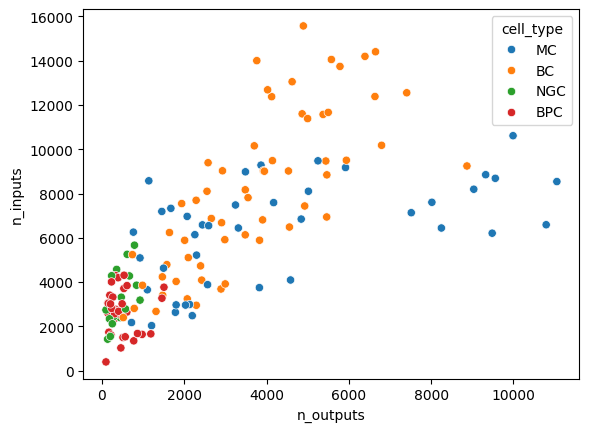

In [18]:
f, ax = plt.subplots()
sns.scatterplot(x='n_outputs', y='n_inputs', hue='cell_type',palette ='tab10', data = in_out_df)